In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

In [3]:
# Generate a synthetic dataset with 200 samples using the 'make_moons' function, with added noise.
X,y = sklearn.datasets.make_moons(200, noise = 0.15)

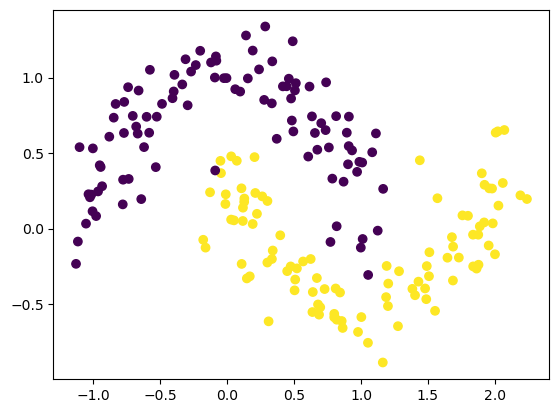

In [4]:
# Plot the generated synthetic dataset with different colors for each class.
# X[:,0] and X[:,1] represent the first and second feature (coordinates) of all samples in the dataset 'X'.
plt.scatter(X[:,0],X[:,1], c=y)

In [5]:
print(X.shape, y.shape)

(200, 2) (200,)


In [6]:
# Setting up the parameters for the neural network and training process:

input_neurons = 2 # Number of input neurons set to 2, matching the number of features in the dataset.
output_neurons = 2 # Number of output neurons set to 2, typically used for binary classification with one-hot encoding.
samples = X.shape[0] # Total number of samples in the dataset.
learning_rate = 0.001 # Learning rate for the optimizer, controlling how much the weights are adjusted during training.
lambda_reg = 0.01 # Regularization parameter (lambda) to prevent overfitting by penalizing large weights.

In [7]:
# Defining a function 'retrieve' to extract model parameters (weights and biases) from a dictionary:

def retreive(model_dict):
    # Extract the first layer's weights and bias.
    W1 = model_dict['W1']
    b1 = model_dict['b1']
    # Extract the second layer's weights and bias.
    W2 = model_dict['W2']
    b2 = model_dict['b2']
    
    # Return the extracted weights and biases.
    return W1, b1, W2, b2

In [8]:
# Defining the forward pass function for the neural network:
# Note: The 'dot' function performs a matrix multiplication between two arrays.

def forward(x, model_dict):
    W1, b1, W2, b2 = retreive(model_dict) # Retrieve the model's weights and biases.
    z1 = X.dot(W1) + b1 # Compute the first layer's linear transformation.
    a1 = np.tanh(z1) # Apply the tanh activation function.
    z2 = a1.dot(W2) + b2 # Compute the second layer's linear transformation.
    exp_scores = np.exp(z2)
    
    # Apply the softmax function to the second layer's output for classification.
    softmax = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True) 
    
    # Return the intermediate values and the final output.
    return z1, a1, softmax

In [9]:
# Define the function to calculate the loss for the neural network:

def loss(softmax, y, model_dict):
    W1, b1, W2, b2 = retreive(model_dict) # Retrieve the model's weights and biases.
    m = np.zeros(200) # Initialize an array to store the probabilities of the correct class for each sample.
    for i,correct_index in enumerate(y): # Iterate over each sample and its correct class index.
        # Extract the predicted probability of the correct class for each sample and store it in the array 'm':
        predicted = softmax[i][correct_index]
        m[i] = predicted
        
    # Compute the negative log likelihood of the correct class probabilities:    
    log_prob = -np.log(m) # Calculate the negative logarithm of the probabilities of the correct classes.
    loss = np.sum(log_prob) # Sum up the negative log probabilities to get the total loss.
    
    # Incorporate regularization to the loss to mitigate overfitting:
    reg_loss = lambda_reg / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2))) # Calculate the regularization loss as the sum of squares of weights of both layers, scaled by the regularization factor.
    loss+= reg_loss # Add the regularization loss to the existing cross-entropy loss.
    
    
    return float(loss / y.shape[0]) # Return the average loss per sample.

In [10]:
# Define the prediction function for the neural network:

def predict(model_dict, x):
    W1, b1, W2, b2 = retreive(model_dict) # Retrieve the model's weights and biases.
    z1 = x.dot(W1) + b1 # Compute the first layer's linear transformation.
    a1 = np.tanh(z1) # Apply the tanh activation function.
    z2 = a1.dot(W2) + b2 # Compute the second layer's linear transformation.
    # Apply the softmax function to convert the output to probability distributions:
    exp_scores = np.exp(z2) 
    softmax = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)   # (200,2)
    
    return np.argmax(softmax, axis = 1)    # (200,) , Identify the index (class) with the highest probability for each sample.

### Equations for Backprop

![backprop](https://user-images.githubusercontent.com/30661597/67566804-3e405980-f75b-11e9-9e19-f3c388745c0a.png)

## $\frac{\partial L}{\partial y_{1}}=-\tilde{y}_{1}\left[\frac{\left(y_{1}\right)^{\prime}}{y_{1}}\right]=-\tilde{y}_{1}\left[\frac{1}{y_{1}}\right]$

## $\frac{\partial y_{1}}{\partial z_{1}}=\frac{\partial}{\partial z_{1}} \cdot \frac{e^{z_{1}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}$

![der](https://user-images.githubusercontent.com/46392773/56460220-ec94cc00-63d1-11e9-91d1-b4e3c57c81fd.png)


## $\frac{\partial L}{\partial y_{1}} \frac{\partial y_{1}}{\partial z_{1}}=-\tilde{y}_{1}\left[\frac{1}{y_{1}}\right]\frac{\partial y_{1}}{\partial z_{1}}=-\tilde{y}_{1}\left[\frac{y_{1}\left(1-y_{1}\right)}{y_{1}}\right]=-\tilde{y}_{1}\left(1-y_{1}\right)$

Recall that our labels are in the form of a one-hot vector: (ex. If class 1 is correct, then the corresponding label is [1,0], if class 2 is correct, then the corresponding label is [0,1]).

If class one is the actual prediction: $\tilde{y}_{1} = 1 $, then we have:

## $\frac{\partial L}{\partial y_{1}} \frac{\partial y_{1}}{\partial z_{1}} = -1(1-y_{1}) = y_{1} - 1 = \delta_{3}$

## $\delta_{2}=\left(1-\tanh ^{2} z_{1}\right) \circ \delta_{3} W_{2}^{T}$

## $\frac{\partial L}{\partial W_{2}}=a_{1}^{T} \delta_{3}$

## $\frac{\partial L}{\partial b_{2}}=\delta_{3}$

## $\frac{\partial L}{\partial W_{1}}=x^{T} \delta 2$

## $\frac{\partial L}{\partial b_{1}}=\delta 2$

In [11]:
# Define the backpropagation function to train the neural network:

def backpropagation(x, y, model_dict, epochs):
    for i in range(epochs):
        W1, b1, W2, b2 = retreive(model_dict) # Retrieve the current weights and biases.
        z1, a1, probs = forward(x, model_dict)    # a1: (200,3), probs: (200,2) ; Perform a forward pass to get the activations and probabilities.
        
        # Calculate the output layer error (delta3):
        delta3 = np.copy(probs) # Create a copy of the softmax probabilities.
        delta3[range(x.shape[0]), y] -= 1      # (200,2) ; Subtract 1 from the probabilities of the correct classes.
        
        # Calculate gradients for the output layer (dW2, db2):
        dW2 = (a1.T).dot(delta3)  # (3,2) ; Compute the gradient of the weights for the output layer.
        db2 = np.sum(delta3, axis=0, keepdims=True)  # (1,2) ; Compute the gradient of the biases for the output layer.
        
        # Compute the error for the hidden layer by backpropagating the output layer error through the weights and applying the derivative of the tanh activation function:
        delta2 = delta3.dot(W2.T) * (1 - np.power(np.tanh(z1), 2))
        
        # Calculate gradients for the hidden layer (dW1, db1):
        dW1 = np.dot(x.T, delta2) # Compute the gradient of the weights for the hidden layer.
        db1 = np.sum(delta2, axis=0) # Compute the gradient of the biases for the hidden layer.
        
        # Add regularization to the gradients:
        dW2 += lambda_reg * np.sum(W2) # Update the gradient of the weights for the output layer by adding the regularization term.  
        dW1 += lambda_reg * np.sum(W1) # Update the gradient of the weights for the hidden layer by adding the regularization term.
        
        # <<Update Weights: W = W + (-lr*gradient) = W - lr*gradient>>
        # Update the weights and biases of the model using the calculated gradients:
        W1 += -learning_rate * dW1 # Adjust the weights of the hidden layer by subtracting the product of the learning rate and the gradient.
        b1 += -learning_rate * db1 # Adjust the biases of the hidden layer in a similar manner.
        W2 += -learning_rate * dW2 # Adjust the weights of the output layer.
        b2 += -learning_rate * db2 # Adjust the biases of the output layer.
        
        # Update the model dictionary
        model_dict = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Print the loss every 50 epochs
        if i%50 == 0:
            print("Loss at epoch {} is: {:.3f}".format(i,loss(probs, y, model_dict)))
            
    return model_dict

In [12]:
# Define a function to initialize the weights and biases of the neural network:

def init_network(input_dim, hidden_dim, output_dim):
    model = {}
    
    # Xavier Initialization:
    # Initialize the weights for the first (hidden) layer using Xavier Initialization.
    # This helps in keeping the signal from exploding to too high or vanishing to zero.
    # It considers the size of the previous layer (input_dim) for scaling.
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    
    b1 = np.zeros((1, hidden_dim)) # Initialize the biases for the first (hidden) layer to zeros.
    
    # Initialize the weights for the second (output) layer using Xavier Initialization:
    # It considers the size of the previous layer (hidden_dim) for scaling.
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    
    b2 = np.zeros((1, output_dim))  # Initialize the biases for the second (output) layer to zeros.
    
    # Store the initialized weights and biases in the model dictionary:
    model['W1'] = W1
    model['b1'] = b1
    model['W2'] = W2
    model['b2'] = b2
    

    return model  # Return the model dictionary containing the initialized parameters.

In [13]:
# Define a function to plot the decision boundary of the neural network:

def plot_decision_boundary(pred_func): 
    """
    Code adopted from: https://github.com/dennybritz/nn-from-scratch
    """
    # Determine the minimum and maximum values of X features, and add some padding:
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    # Set the step size for the meshgrid:
    h = 0.01 
    
    # Create a meshgrid between x_min and x_max, y_min and y_max with step size h.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    
    # Flatten the grid arrays and combine them into a single array of coordinate pairs:
    # 'ravel' is used to flatten the 2D arrays into 1D arrays.
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    
    # Reshape the predictions to match the shape of the meshgrid for plotting:
    Z = Z.reshape(xx.shape) 
    
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 
    plt.title("Decision Boundary for hidden layer size 3")

Loss at epoch 0 is: 0.690
Loss at epoch 50 is: 0.312
Loss at epoch 100 is: 0.284
Loss at epoch 150 is: 0.278
Loss at epoch 200 is: 0.274
Loss at epoch 250 is: 0.270
Loss at epoch 300 is: 0.265
Loss at epoch 350 is: 0.257
Loss at epoch 400 is: 0.246
Loss at epoch 450 is: 0.231
Loss at epoch 500 is: 0.213
Loss at epoch 550 is: 0.194
Loss at epoch 600 is: 0.174
Loss at epoch 650 is: 0.155
Loss at epoch 700 is: 0.137
Loss at epoch 750 is: 0.122
Loss at epoch 800 is: 0.109
Loss at epoch 850 is: 0.098
Loss at epoch 900 is: 0.089
Loss at epoch 950 is: 0.082


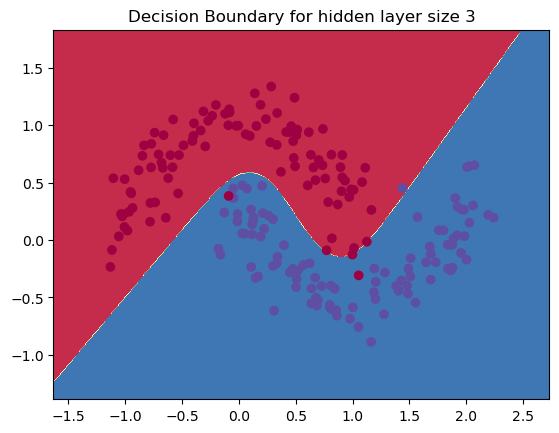

In [14]:
# Initialize the neural network, train it, and plot its decision boundary:

# Initialize the neural network with specified dimensions:
model_dict = init_network(input_dim = input_neurons , hidden_dim = 3, output_dim = output_neurons)

# Train the neural network using backpropagation for 1000 epochs:
model = backpropagation(X, y, model_dict, 1000)

# Plot the decision boundary of the trained model.
# The lambda function is used to create an anonymous function that takes 'x' as input and returns the predictions from the model.
plot_decision_boundary(lambda x: predict(model, x))